# Customer Retention: Cohort Analysis 📊
**Oleh: Wisma Jaya Laksana**

Selain mencari tahu *siapa* pelanggan terbaik kita (lewat RFM), bisnis yang sehat harus tahu *apakah pelanggan kita setia?* Notebook ini berisi analisis **Customer Retention** menggunakan metode **Cohort Analysis**. Kita akan mengelompokkan pelanggan berdasarkan "Angkatan" (kapan mereka pertama kali berbelanja) dan melacak persentase dari mereka yang kembali berbelanja di bulan-bulan berikutnya.

Tujuan analisis ini: *"Dari 100 orang yang mencoba produk kita di bulan pertama, berapa banyak yang bertahan menjadi pelanggan rutin?"*

## 1. Data Preparation & Penentuan "Angkatan" (Cohort)
Langkah pertama setelah membersihkan data dari nilai kosong dan transaksi retur adalah membuat dua pilar waktu utama:
1. **InvoiceMonth:** Bulan terjadinya transaksi.
2. **CohortMonth:** Bulan di mana pelanggan tersebut **pertama kali** berbelanja di toko kita (Angkatan pelanggan).

In [6]:
import pandas as pd
import datetime as dt

print("⏳ Loading data...")
# 1. Load data mentah
df = pd.read_csv('../data/Online Retail.csv', encoding='unicode_escape')

# 2. Data Cleaning dasar (Hapus ID kosong & Retur)
df = df.dropna(subset=['CustomerID'])
df = df[df['Quantity'] > 0]

# 3. Ubah kolom InvoiceDate jadi tipe Datetime (biar bisa diolah)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# 4. Fungsi pembantu: Ubah tanggal berapapun jadi tanggal 1 (Fokus ke Tahun-Bulan saja)
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

# 5. Bikin kolom 'InvoiceMonth'
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)

# 6. Bikin kolom 'CohortMonth' (Bulan PERTAMA pelanggan gabung)
# Logika: Cari tanggal transaksi (InvoiceMonth) paling kecil (min) untuk setiap CustomerID
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')

# Kita intip hasilnya
print("✅ Selesai! Ini hasilnya:")
display(df[['CustomerID', 'InvoiceDate', 'InvoiceMonth', 'CohortMonth']].head(10))

⏳ Loading data...
✅ Selesai! Ini hasilnya:


,CustomerID,InvoiceDate,InvoiceMonth,CohortMonth
0,17850.0,2010-12-01 08:26:00,2010-12-01,2010-12-01
1,17850.0,2010-12-01 08:26:00,2010-12-01,2010-12-01
2,17850.0,2010-12-01 08:26:00,2010-12-01,2010-12-01
3,17850.0,2010-12-01 08:26:00,2010-12-01,2010-12-01
4,17850.0,2010-12-01 08:26:00,2010-12-01,2010-12-01
5,17850.0,2010-12-01 08:26:00,2010-12-01,2010-12-01
6,17850.0,2010-12-01 08:26:00,2010-12-01,2010-12-01
7,17850.0,2010-12-01 08:28:00,2010-12-01,2010-12-01
8,17850.0,2010-12-01 08:28:00,2010-12-01,2010-12-01
9,13047.0,2010-12-01 08:34:00,2010-12-01,2010-12-01


## 2. Menghitung "Umur" Pelanggan (Cohort Index)
Setelah tahu kapan mereka pertama kali gabung, kita perlu menghitung selisih waktu antara tanggal transaksi dengan tanggal pertama kali gabung. 

Selisih ini disebut **Cohort Index**. 
* Index 1 = Transaksi di bulan pertama mereka gabung.
* Index 2 = Transaksi di bulan kedua, dan seterusnya.

In [7]:
# 1. Bikin fungsi pembantu untuk ekstrak angka Tahun dan Bulan
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    return year, month

# 2. Ambil angka Tahun & Bulan dari InvoiceMonth (Tanggal Belanja)
invoice_year, invoice_month = get_date_int(df, 'InvoiceMonth')

# 3. Ambil angka Tahun & Bulan dari CohortMonth (Tanggal Gabung)
cohort_year, cohort_month = get_date_int(df, 'CohortMonth')

# 4. Hitung selisih Tahun dan Bulan
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

# 5. Rumus Cohort Index (+1 supaya bulan pertama dihitung 1, bukan 0)
df['CohortIndex'] = years_diff * 12 + months_diff + 1

print("✅ Cohort Index berhasil dibuat!")

# Kita intip data secara acak (biar kelihatan yang belanjanya di bulan ke-2, ke-3, dst)
display(df[['CustomerID', 'InvoiceMonth', 'CohortMonth', 'CohortIndex']].sample(10, random_state=42))

✅ Cohort Index berhasil dibuat!


,CustomerID,InvoiceMonth,CohortMonth,CohortIndex
480132,16764.0,2011-11-01,2011-07-01,5
401231,13015.0,2011-10-01,2011-04-01,7
338588,18145.0,2011-09-01,2011-01-01,9
227508,16461.0,2011-06-01,2011-06-01,1
315994,17346.0,2011-08-01,2010-12-01,9
409114,14527.0,2011-10-01,2010-12-01,11
396027,14234.0,2011-10-01,2011-10-01,1
401981,16729.0,2011-10-01,2011-04-01,7
56735,18085.0,2011-01-01,2010-12-01,2
131677,13488.0,2011-03-01,2010-12-01,4


## 3. Membuat Tabel Retention Rate (Pivot Table)
Di tahap ini, kita mengubah data mentah menjadi metrik persentase. Kita akan menghitung berapa jumlah pelanggan unik di bulan pertama (sebagai pembagi 100%), lalu menghitung berapa persen yang tersisa di bulan ke-2, ke-3, dst. Hasilnya akan dibentuk menjadi *Pivot Table* berbentuk matriks segitiga.

In [8]:
# 1. Hitung jumlah CustomerID unik untuk setiap kombinasi CohortMonth & CohortIndex
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()

# 2. Susun jadi Pivot Table (Jumlah Orang)
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# 3. Ambil jumlah pelanggan di Bulan ke-1 (Sebagai patokan 100%)
cohort_sizes = cohort_counts.iloc[:, 0]

# 4. Hitung persentase Retention (Bagi semua data dengan patokan 100% tadi)
retention = cohort_counts.divide(cohort_sizes, axis=0)

# 5. Rapikan format tampilan (Ubah jadi persen dan rapikan nama bulan)
retention.index = retention.index.strftime('%Y-%m')

print("✅ Tabel Retention Rate berhasil dibuat!")
# Tampilkan hasilnya (Biar lebih enak dilihat, kita kalikan 100)
display(retention.round(3) * 100)

✅ Tabel Retention Rate berhasil dibuat!


CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,100.0,36.6,32.3,38.4,36.3,39.8,36.3,34.9,35.4,39.5,37.4,50.3,26.6
2011-01,100.0,22.1,26.6,23.0,32.1,28.8,24.7,24.2,30.0,32.6,36.5,11.8,NaN
2011-02,100.0,18.7,18.7,28.4,27.1,24.7,25.3,27.9,24.7,30.5,6.8,NaN,NaN
2011-03,100.0,15.0,25.2,19.9,22.3,16.8,26.8,23.0,27.9,8.6,NaN,NaN,NaN
2011-04,100.0,21.3,20.3,21.0,19.7,22.7,21.7,26.0,7.3,NaN,NaN,NaN,NaN
2011-05,100.0,19.0,17.3,17.3,20.8,23.2,26.4,9.5,NaN,NaN,NaN,NaN,NaN
2011-06,100.0,17.4,15.7,26.4,23.1,33.5,9.5,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,100.0,18.1,20.7,22.3,27.1,11.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,100.0,20.7,24.9,24.3,12.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 4. Visualisasi Heatmap & Business Insight
Angka dalam bentuk tabel seringkali sulit dibaca dengan cepat. Oleh karena itu, kita mengubah tabel *retention* tersebut menjadi visualisasi **Heatmap**. Semakin gelap warnanya, semakin tinggi persentase pelanggan yang kembali (*retention rate* bagus).

### 💡 Key Insights:
1. **Drop-off di Bulan Kedua:** Secara umum, terjadi penurunan drastis (*drop-off*) di bulan kedua (rata-rata hanya tersisa ~20%). Ini menunjukkan banyak pelanggan yang hanya "coba-coba" atau berbelanja untuk kebutuhan insidentil satu kali saja.
2. **Anomali Seasonality (The 50% Spike):** Ada temuan menarik pada angkatan **2010-12** (Desember 2010). Tepat di bulan ke-12 (Desember 2011), *retention rate* tiba-tiba melonjak drastis mencapai **50%**. Ini membuktikan adanya efek musiman (*seasonality*) yang sangat kuat, di mana pelanggan lama sengaja kembali untuk berbelanja kebutuhan akhir tahun (Natal & Tahun Baru).

**Rekomendasi:**
Tim Marketing harus menyiapkan *budget* retargeting yang masif khusus di bulan November/Desember untuk "membangunkan" pelanggan lama, karena probabilitas mereka untuk kembali berbelanja di momen tersebut terbukti sangat tinggi.

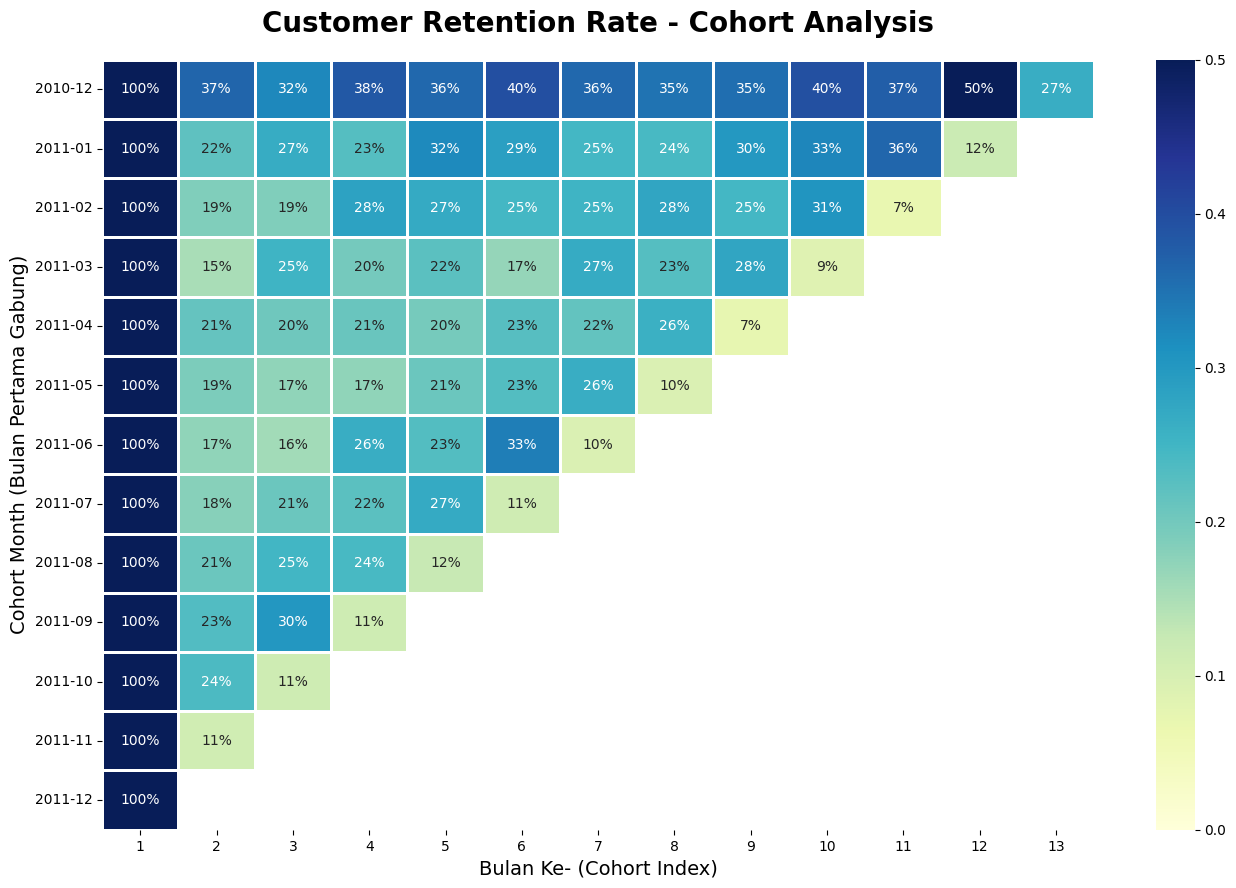

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Siapkan Kanvas
plt.figure(figsize=(16, 10))
plt.title('Customer Retention Rate - Cohort Analysis', fontsize=20, fontweight='bold', pad=20)

# 2. Buat Heatmap
# Kita pakai data 'retention' (yang isinya desimal 0.36, dll)
# fmt='.0%' akan otomatis mengubahnya jadi tampilan persen (36%)
# cmap='YlGnBu' itu tema warna: Yellow-Green-Blue (makin biru makin bagus)
sns.heatmap(retention, 
            annot=True, 
            fmt='.0%', 
            cmap='YlGnBu', 
            vmin=0.0, 
            vmax=0.5, # Kita set maksimal warna di 50% biar gradasinya kelihatan jelas
            linewidths=1, 
            linecolor='white')

# 3. Rapikan Label
plt.ylabel('Cohort Month (Bulan Pertama Gabung)', fontsize=14)
plt.xlabel('Bulan Ke- (Cohort Index)', fontsize=14)
plt.yticks(rotation=0) 

# 4. Tampilkan!
plt.show()

In [10]:
# Simpan hasil retention ke folder data
retention.to_csv('../data/Hasil_Cohort_Retention_Wisma.csv')
print("✅ Data Cohort Retention berhasil disimpan!")

✅ Data Cohort Retention berhasil disimpan!
